In [2]:

# # install and import libraries
# !pip install lazypredict
# !pip install shap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Scikit Learn
from sklearn.model_selection import KFold, cross_val_score, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.utils import shuffle
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error, r2_score

# Models
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Other Tools
import lazypredict
from lazypredict.Supervised import LazyRegressor
import shap
from joblib import dump, load

In [4]:
# Load in and configure the data
ndvi_df = pd.read_csv('NDVI_clean_preprocessed_shorttermdrought.csv')
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
ndvi_df = ndvi_df.set_index('date')

# Get column names that end with "_anomaly_roll"
columns_to_rename = [col for col in ndvi_df.columns if col.endswith('_anomaly_roll')]

# Create a mapping of old column names to new column names
rename_dict = {col: col[:-len('_anomaly_roll')].upper() for col in columns_to_rename}

# Rename columns in the DataFrame and capitalize column names
ndvi_df.rename(columns=rename_dict, inplace=True)
ndvi_df.rename(columns={'TMIN': 'Tmin', 'TMAX': 'Tmax', 'PRECIP': 'Precip', 'PALMERZ': 'PalmerZ',}, inplace=True)

# Check the df's columns
ndvi_df.columns

Index(['NDVI', 'SWE', 'Tmin', 'Tmax', 'Precip', 'PDSI', 'EDDI30', 'EDDI90',
       'EDDI180', 'SPEI30', 'SPEI90', 'SPEI180', 'SPI30', 'SPI90', 'SPI180',
       'PalmerZ'],
      dtype='object')

In [6]:
# Select the columns based V1 model results
ndvi_df = ndvi_df[['NDVI', 'SWE', 'Tmin', 'Tmax', 'Precip', 'PDSI', 'EDDI30', 'EDDI90',
       'EDDI180', 'SPEI30', 'SPEI90', 'SPEI180', 'SPI30', 'SPI90', 'SPI180',
       'PalmerZ']]
ndvi_df

,NDVI,SWE,Tmin,Tmax,Precip,PDSI,EDDI30,EDDI90,EDDI180,SPEI30,SPEI90,SPEI180,SPI30,SPI90,SPI180,PalmerZ
date,,,,,,,,,,,,,,,,
2000-02-29,0.78,0.02,3.87,3.20,0.59,0.57,0.33,0.19,0.50,0.18,-0.05,-0.46,0.82,0.34,-0.51,0.22
2000-03-05,0.36,-0.43,3.35,3.17,0.14,0.56,0.57,0.30,0.61,-0.06,-0.11,-0.66,0.70,0.33,-0.77,0.10
2000-03-10,0.29,-0.81,2.55,2.29,1.80,0.56,0.61,0.33,0.68,0.29,0.08,-0.68,1.12,0.65,-0.69,0.42
2000-03-15,0.07,-0.92,1.68,1.55,1.17,0.57,0.64,0.29,0.71,0.39,0.24,-0.69,1.22,0.84,-0.63,0.51
2000-03-20,0.01,-0.95,1.25,1.19,1.11,0.58,0.63,0.27,0.76,0.47,0.35,-0.71,1.30,0.97,-0.58,0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-06,0.68,-0.48,1.73,1.59,-0.31,-0.25,0.90,1.15,1.27,-0.92,0.01,-0.66,-0.49,0.82,0.29,-0.32
2021-12-11,0.68,-0.51,1.59,1.53,0.10,-0.27,1.20,1.22,1.30,-1.25,-0.04,-0.63,-0.52,0.81,0.36,-0.42
2021-12-16,0.40,-0.51,1.54,1.40,0.12,-0.28,1.37,1.31,1.32,-1.43,-0.06,-0.56,-0.53,0.82,0.46,-0.48


In [7]:
# Based on our results above, select the last 20% of the data to be our test set
# Define our x and y variables
X = ndvi_df.iloc[:, 1:].values
y = ndvi_df.iloc[:, 0].values.ravel()

# Split up the test and training data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Training data shape - x_train: ", x_train.shape)
print("Training data shape - y_train: ", y_train.shape)
print("Testing data shape - x_test: ", x_test.shape)
print("Testing data shape - y_test: ", y_test.shape)

Training data shape - x_train:  (1272, 15)
Training data shape - y_train:  (1272,)
Testing data shape - x_test:  (318, 15)
Testing data shape - y_test:  (318,)


In [8]:
# Define your model
xgb_model = XGBRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=False)#, random_state=42)

# Run k-fold cross validation on the model
results = cross_val_score(xgb_model, x_train, y_train, cv=kfold, scoring='r2')

# Fit the model to the training data
xgb_model.fit(x_train, y_train)

# Use the trained model to make predictions on the test data
y_pred = xgb_model.predict(x_test)

# Calculate the model performance metrics on the test data
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the cross validation and test results
print("Cross Val Results:", results)
print("Cross Val Mean Result:", results.mean())

print('Test Mean Squared Error:', mse)
print('Test Root Mean Squared Error:', rmse)
print('Test R-squared:', r2)

Cross Val Results: [0.30174211 0.60873445 0.30534515 0.19463378 0.04342077]
Cross Val Mean Result: 0.2907752539430356
Test Mean Squared Error: 0.6059653812930572
Test Root Mean Squared Error: 0.7784377825446663
Test R-squared: 0.41792237764204576


In [9]:
# Define the distribution of hyperparameters to search over
param_dist = {
    'learning_rate': uniform(0.01, 1),
    'max_depth': randint(0, 15),
    'min_child_weight': randint(0, 25),
    'subsample': uniform(0.01, 1),
    'colsample_bytree': uniform(0.01, 1),
    'n_estimators': randint(1, 2000)
}

# Define the regression model
xgb = XGBRegressor(random_state=42)

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=False)

# Define the random search object
random_search = RandomizedSearchCV(xgb, param_distributions=param_dist, cv=kfold, n_iter=100, random_state=42, verbose=3)

# Fit the random search to the training data
random_search.fit(x_train, y_train)



Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END colsample_bytree=0.3845401188473625, learning_rate=0.9607143064099162, max_depth=10, min_child_weight=7, n_estimators=1725, subsample=0.606850157946487;, score=-0.650 total time=   0.5s
[CV 2/5] END colsample_bytree=0.3845401188473625, learning_rate=0.9607143064099162, max_depth=10, min_child_weight=7, n_estimators=1725, subsample=0.606850157946487;, score=-0.312 total time=   0.4s
[CV 3/5] END colsample_bytree=0.3845401188473625, learning_rate=0.9607143064099162, max_depth=10, min_child_weight=7, n_estimators=1725, subsample=0.606850157946487;, score=-0.634 total time=   0.5s
[CV 4/5] END colsample_bytree=0.3845401188473625, learning_rate=0.9607143064099162, max_depth=10, min_child_weight=7, n_estimators=1725, subsample=0.606850157946487;, score=-0.379 total time=   0.4s
[CV 5/5] END colsample_bytree=0.3845401188473625, learning_rate=0.9607143064099162, max_depth=10, min_child_weight=7, n_estimators=1725, subs

In [10]:
# Predict the test data using the best trained model
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

# Calculate R2 score on the predicted test data
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameters and best score, and R2 score from the test set
print("Best hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)
print("R2 Score: ", r2)

Best hyperparameters:  {'colsample_bytree': 0.7996181427945539, 'learning_rate': 0.10120610304869036, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 398, 'subsample': 0.5595288823237355}
Best score:  0.36329828107967005
R2 Score:  0.509972180241627


In [13]:
# Define the distribution of hyperparameters to search over
param_dist = {
    'learning_rate': [0.3],
    'max_depth': [6],
    'min_child_weight': [1],
    'subsample': [1],
    'colsample_bytree': [1],
    'n_estimators': [372, 373, 374]
}

# Define the regression model
xgb = XGBRegressor(objective='reg:squarederror')

# Define the number of folds for cross validation
num_folds = 5

# Define the k-fold cross validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state = 42)

# Define the search object
grid_search = GridSearchCV(xgb, param_dist, cv=kfold, verbose = 3)

# Fit the grid search to the training data
grid_search.fit(x_train, y_train)



Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END colsample_bytree=1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=372, subsample=1;, score=0.871 total time=   0.5s
[CV 2/5] END colsample_bytree=1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=372, subsample=1;, score=0.890 total time=   0.4s
[CV 3/5] END colsample_bytree=1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=372, subsample=1;, score=0.911 total time=   0.5s
[CV 4/5] END colsample_bytree=1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=372, subsample=1;, score=0.887 total time=   0.4s
[CV 5/5] END colsample_bytree=1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=372, subsample=1;, score=0.876 total time=   0.5s
[CV 1/5] END colsample_bytree=1, learning_rate=0.3, max_depth=6, min_child_weight=1, n_estimators=373, subsample=1;, score=0.871 total time=   0.5s
[CV 2/5] END colsample_bytree=1, learning_rate=0.3, 

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [1], 'learning_rate': [0.3],
                         'max_depth': [6], 'min_child_weight': [1],
                         'n_estimators': [372, 373, 374], 'subsample': [1]},
             verbose=3)

In [14]:
# Predict the test data using the best trained model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

# Calculate R2 score on the predicted test data
r2 = r2_score(y_test, y_pred)

# Print the best hyperparameters and best score, and R2 score from the test set
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
print("R2 Score: ", r2)

Best hyperparameters:  {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 372, 'subsample': 1}
Best score:  0.8870260337903739
R2 Score:  0.41935433356999696


In [16]:
# Define our x and y variables
X = ndvi_df.iloc[:, 1:].values
y = ndvi_df.iloc[:, 0].values.ravel()

# Split up the test and training data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Training data shape - x_train: ", x_train.shape)
print("Training data shape - y_train: ", y_train.shape)
print("Testing data shape - x_test: ", x_test.shape)
print("Testing data shape - y_test: ", y_test.shape)

Training data shape - x_train:  (1272, 15)
Training data shape - y_train:  (1272,)
Testing data shape - x_test:  (318, 15)
Testing data shape - y_test:  (318,)


In [17]:
# XGBoost
# Define the model based on the best parameters
xg_reg = XGBRegressor(colsample_bytree = 1,
                      learning_rate = 0.3,
                      max_depth = 6,
                      min_child_weight = 1,
                      n_estimators = 373,
                      subsample = 1)

# Fit the model to the training data
xg_reg.fit(x_train, y_train)

# Save the model for reproducibility
dump(xg_reg, 'xgb_reg_v2.joblib')

['xgb_reg_v2.joblib']

In [18]:
# Load the model
xg_reg = load('xgb_reg_v2.joblib')

# Use the trained model to make predictions on the test data
xg_y_pred = xg_reg.predict(x_test)

# Calculate the model performance metrics on the test data
mse = mean_squared_error(y_test, xg_y_pred )
rmse = np.sqrt(mse)
r2 = r2_score(y_test, xg_y_pred )

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared:', r2)

Mean Squared Error: 0.6044746596327375
Root Mean Squared Error: 0.7774796843858607
R-squared: 0.41935433356960194


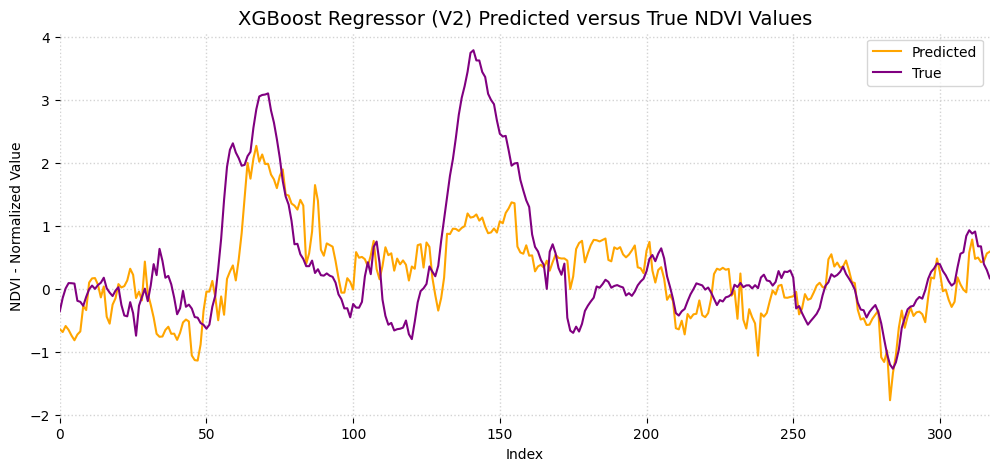

In [20]:
# Set figure size
plt.figure(figsize=(12, 5))

# Plot the predicted values in orange
plt.plot(xg_y_pred, label='Predicted', color='orange')

# Plot the true values (`y_test`) in purple
plt.plot(y_test, label='True', color='purple')

# Set x-axis limit to start and stop with the data
plt.xlim(0, len(xg_y_pred)-1)

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('NDVI - Normalized Value')
plt.title("XGBoost Regressor (V2) Predicted versus True NDVI Values", fontsize=14)
plt.legend()

# Remove the border around the plot
plt.box(False)

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)

# Show the plot
plt.show()

In [21]:
# XGB
# Get feature importance scores
importance = xg_reg.feature_importances_

# Create a list of feature names
features = list(ndvi_df.columns[1:16])

# Create a dictionary of feature importance scores and feature names
feature_importance = dict(zip(features, importance))

# Sort the dictionary by feature importance scores in descending order
sorted_feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Print the feature importance ranking
print("Feature Importance Ranking:")
for feature, importance_score in sorted_feature_importance:
    print(feature, ":", importance_score)



Feature Importance Ranking:
PDSI : 0.37570205
SPI90 : 0.13455676
PalmerZ : 0.12556253
SPI180 : 0.09080695
SWE : 0.0589015
SPEI180 : 0.043054394
EDDI180 : 0.03991643
EDDI90 : 0.035362378
SPEI90 : 0.026283713
Precip : 0.019266753
SPI30 : 0.0134676425
EDDI30 : 0.012336699
Tmax : 0.009649191
Tmin : 0.008194853
SPEI30 : 0.0069381422


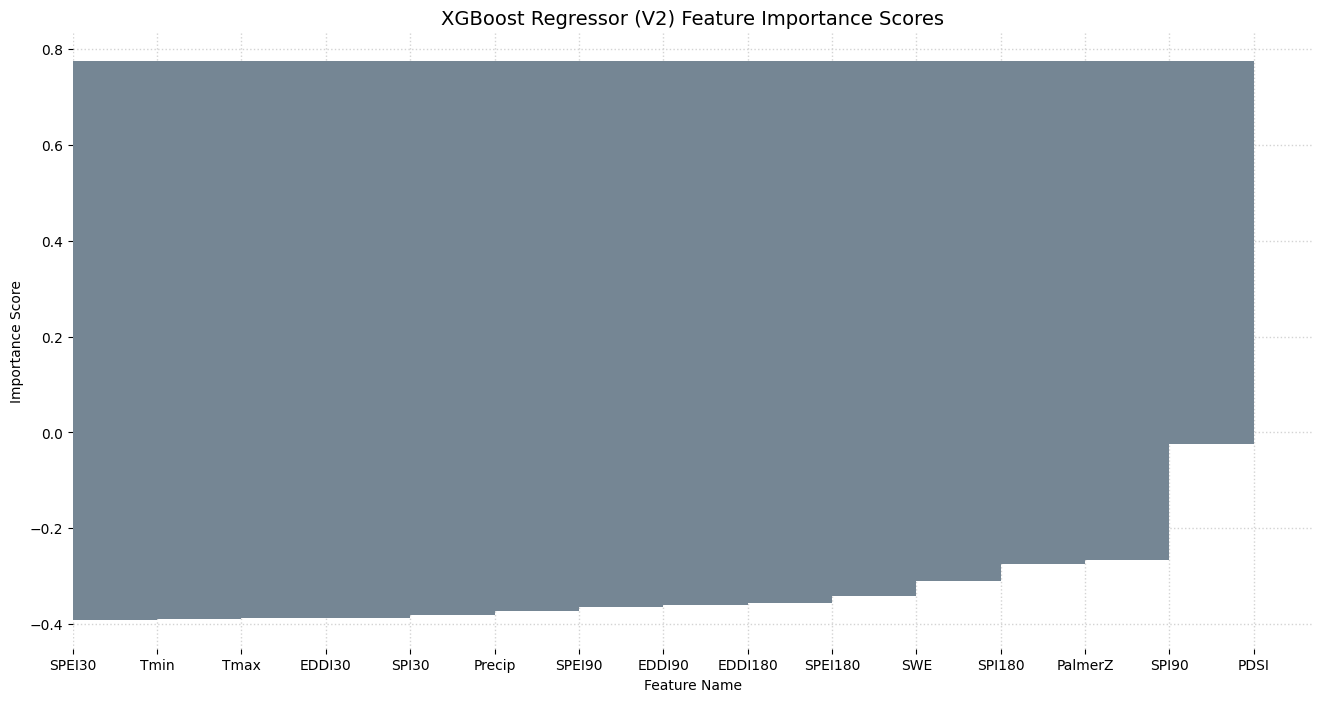

In [27]:
# Create a list of feature names and importance scores, in reverse order
features = [x[0] for x in reversed(sorted_feature_importance)]
importance_scores = [x[1] for x in reversed(sorted_feature_importance)]

# Set the desired style
plt.style.use('default')

# Set figure size
plt.figure(figsize=(16, 8))

# Create a horizontal bar chart
plt.barh( importance_scores,features, color='#758694')

# Add a title and axis labels
plt.title('XGBoost Regressor (V2) Feature Importance Scores', fontsize=14)
plt.xlabel('Feature Name')
plt.ylabel('Importance Score')

# Remove the border around the plot
plt.box(False)

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)

# Display the chart
plt.show()

In [29]:

#create a feature name variable that should match the below
feature_names = ['PDSI', 'Palmer Z', 'SWE', 'EDDI 1-Year','EDDI 5-Year', 'SPEI 270-Day',
       'SPEI 1-Year', 'SPEI 2-Year', 'SPEI 5-Year', 'SPI 90-Day', 'SPI 180-Day', 'SPI 270-Day', 'SPI 1-Year',
       'SPI 2-Year', 'SPI 5-Year']

ndvi_df.columns[1:]

Index(['SWE', 'Tmin', 'Tmax', 'Precip', 'PDSI', 'EDDI30', 'EDDI90', 'EDDI180',
       'SPEI30', 'SPEI90', 'SPEI180', 'SPI30', 'SPI90', 'SPI180', 'PalmerZ'],
      dtype='object')

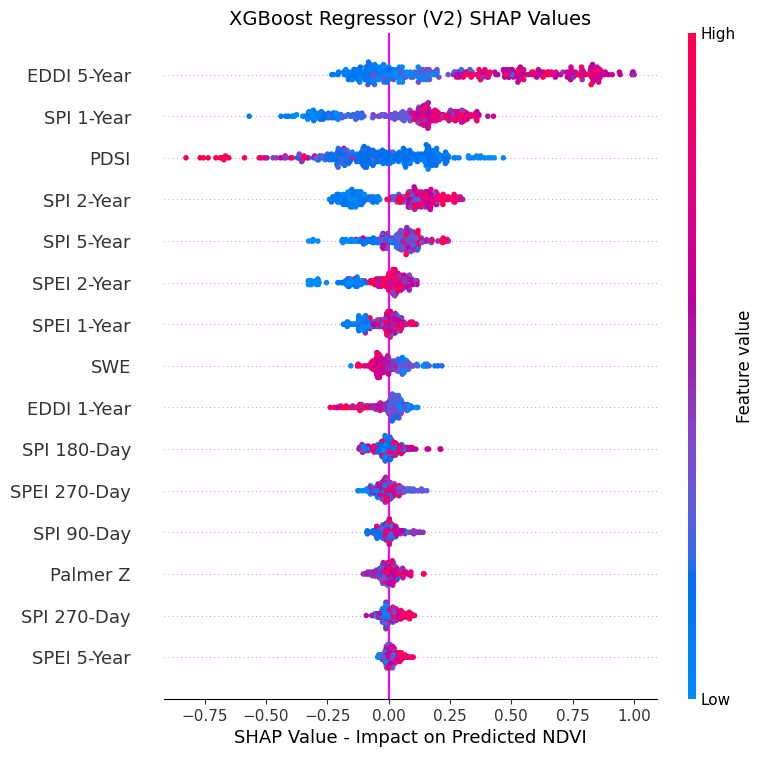

In [42]:
import shap
import matplotlib.pyplot as plt

# Load the model
xg_reg = load('xgb_reg_v2.joblib')

# Use the model to make predictions
xg_y_pred = xg_reg.predict(x_test)

# Explain results using SHAP
xg_explainer = shap.Explainer(xg_reg)
xg_shap_values = xg_explainer(x_test)

# Summary plot with default colors
shap.summary_plot(xg_shap_values, features=x_test, feature_names=feature_names, show=False)

# Customize the colors of the summary plot
plt.title("XGBoost Regressor (V2) SHAP Values", fontsize=14)
plt.xlabel('SHAP Value - Impact on Predicted NDVI')

# Customizing color of beeswarm plot points
for collection in plt.gca().collections:
    collection.set_color('cyan')  # Change to your desired color

# Customizing color of bars
for line in plt.gca().lines:
    line.set_color('magenta')  # Change to your desired color

plt.show()


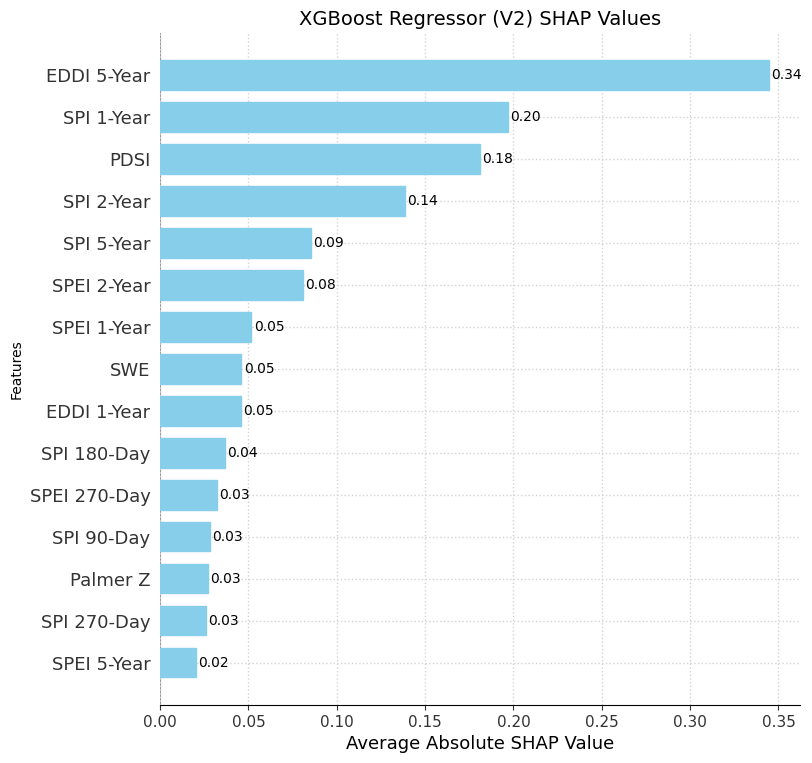

In [45]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Load the model
xg_reg = load('xgb_reg_v2.joblib')

# Use the model to make predictions
xg_y_pred = xg_reg.predict(x_test)

# Explain results using SHAP
xg_explainer = shap.Explainer(xg_reg)
xg_shap_values = xg_explainer(x_test)

# Summary plot with bar type
shap.summary_plot(xg_shap_values, features=x_test, feature_names=feature_names, plot_type="bar", show=False)

# Customizing the plot
plt.title("XGBoost Regressor (V2) SHAP Values", fontsize=14)
plt.xlabel('Average Absolute SHAP Value')
plt.ylabel('Features')

# Customizing colors
bars = plt.gca().patches
for bar in bars:
    bar.set_color('skyblue')  # Change to your desired color

# Adding value labels on top of the bars
for bar in bars:
    plt.gca().text(
        bar.get_width() + 0.01,
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.2f}',
        ha='center',
        va='center'
    )

# Set the grid to be drawn below the bars
plt.gca().set_axisbelow(True)

# Add a light grid in the background
plt.grid(color='lightgray', linestyle=':', linewidth=1)

# Show the plot
plt.show()


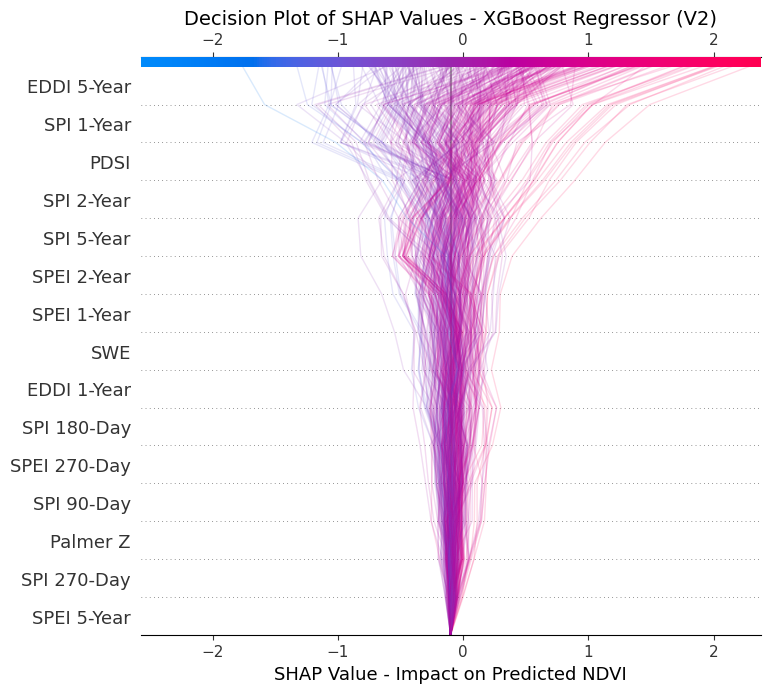

In [52]:
# Load the model
xg_reg = load('xgb_reg_v2.joblib')

# Use the model to make predictions
xg_y_pred = xg_reg.predict(x_test)

# Explain results using SHAP
xg_explainer = shap.Explainer(xg_reg)
xg_shap_values = xg_explainer(x_test)

# Decision plot with custom alpha value
shap.decision_plot(xg_explainer.expected_value, xg_shap_values.values, feature_names=feature_names, show=False, alpha=0.15)

# Customizing the plot
plt.title("Decision Plot of SHAP Values - XGBoost Regressor (V2)", fontsize=14)
plt.xlabel('SHAP Value - Impact on Predicted NDVI')



# Show the plot
plt.show()